In [1]:
!pip install transformers==3.0.2

In [2]:
# Importing libraries
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/dep1_cleaned.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


##Partitioning

###IID

In [6]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [7]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

# MAIN

## MODELS

In [8]:
#Base Roberta model
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [9]:
model = RobertaClass()
model.to(device)

RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, eleme

In [10]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [11]:
class TweetData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def get_labels(self):
      l = []
      for i in range(len(self.data)):
        # text = str(self.text[i])
        # text = " ".join(text.split())

        # inputs = self.tokenizer.encode_plus(
        #     text,
        #     None,
        #     add_special_tokens=True,
        #     max_length=self.max_len,
        #     pad_to_max_length=True,
        #     return_token_type_ids=True
        # )

        l.append(self.targets[i])

      return l     


    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [12]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.text = dataset.tweet
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.targets = self.data.target
      
  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      text = str(self.text[index])
      text = " ".join(text.split())

      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      token_type_ids = inputs["token_type_ids"]


      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets[index], dtype=torch.float)
      }

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []
    
    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      model.train()

      for _,data in enumerate(self.train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = self.model(ids, mask, token_type_ids)
        loss = self.loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += self.calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        self.optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        self.optimizer.step()

      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      print("-------------------------------")
      epochloss.append(epoch_loss)
      epochacc.append(epoch_accu)

    return model.state_dict(), epochacc[-1], epochloss[-1]

In [13]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E,plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []

  optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")
  
  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

In [14]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = TweetData(train_dataset, tokenizer, MAX_LEN)
testing_set = TweetData(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3096, 3)
TRAIN Dataset: (2477, 3)
TEST Dataset: (619, 3)


In [15]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

Training Loss per 5000 steps: 1.700748085975647
Training Accuracy per 5000 steps: 0.0
The Total Accuracy for Epoch 1: 51.012145748987855
Training Loss Epoch: 1.3519107257166216
Training Accuracy Epoch: 51.012145748987855
-------------------------------
Training Loss per 5000 steps: 0.8204828500747681
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 1: 75.30364372469636
Training Loss Epoch: 0.6948380249161874
Training Accuracy Epoch: 75.30364372469636
-------------------------------
Training Loss per 5000 steps: 0.777527391910553
Training Accuracy per 5000 steps: 62.5
The Total Accuracy for Epoch 1: 74.89878542510121
Training Loss Epoch: 0.5783961482586399
Training Accuracy Epoch: 74.89878542510121
-------------------------------
Round: 1... 	Average Loss: 0.875
Round: 1... 	Average Accuracy: 67.072
Training Loss per 5000 steps: 0.4711765944957733
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 1: 79.35222672064778
Training Loss Epoch: 0.5321425891

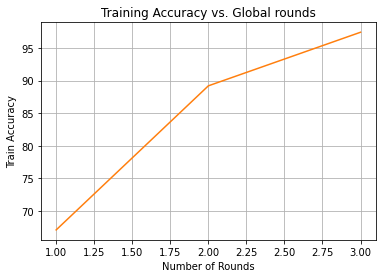

In [16]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [17]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [22]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [23]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


0it [00:00, ?it/s]
3it [00:00, 21.56it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 2.3504159450531006
Validation Accuracy per 100 steps: 50.0



6it [00:00, 21.53it/s]
9it [00:00, 21.75it/s]
12it [00:00, 22.05it/s]
15it [00:00, 22.44it/s]
18it [00:00, 22.80it/s]
21it [00:00, 22.93it/s]
24it [00:01, 23.09it/s]
27it [00:01, 23.20it/s]
30it [00:01, 23.24it/s]
33it [00:01, 23.34it/s]
36it [00:01, 23.31it/s]
39it [00:01, 23.27it/s]
42it [00:01, 23.32it/s]
45it [00:01, 23.24it/s]
48it [00:02, 23.19it/s]
51it [00:02, 23.29it/s]
54it [00:02, 23.45it/s]
57it [00:02, 23.44it/s]
60it [00:02, 23.49it/s]
63it [00:02, 23.39it/s]
66it [00:02, 23.48it/s]
69it [00:02, 23.53it/s]
72it [00:03, 23.49it/s]
75it [00:03, 23.55it/s]
78it [00:03, 23.56it/s]
81it [00:03, 23.58it/s]
84it [00:03, 23.63it/s]
87it [00:03, 23.64it/s]
90it [00:03, 23.45it/s]
93it [00:04, 23.23it/s]
96it [00:04, 23.15it/s]
99it [00:04, 23.19it/s]
102it [00:04, 23.19it/s]
105it [00:04, 23.18it/s]
108it [00:04, 23.14it/s]
111it [00:04, 23.25it/s]
114it [00:04, 23.32it/s]
117it [00:05, 23.34it/s]
120it [00:05, 23.42it/s]
123it [00:05, 23.42it/s]
126it [00:05, 23.52it/s]
129it [0

Validation Loss Epoch: 0.6231158756290472
Validation Accuracy Epoch: 82.87560581583199
Accuracy on test data = 82.88%


Training Loss per 5000 steps: 0.044888824224472046
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.03427646724650493
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 0.017738962545990944
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.017072057638030786
Training Accuracy Epoch: 100.0
-------------------------------
Training Loss per 5000 steps: 0.00947633571922779
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 99.0
Training Loss Epoch: 0.02355564020287532
Training Accuracy Epoch: 99.0
-------------------------------
Round: 1... 	Average Loss: 0.025
Round: 1... 	Average Accuracy: 99.667
Training Loss per 5000 steps: 0.01257936842739582
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 1: 100.0
Training Loss Epoch: 0.021539239929272577
Training Accuracy Epoch: 100.0
-------------------------------

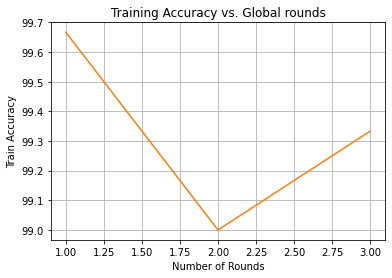

In [24]:
# number of training rounds
rounds = 3
# client fraction
C = 0.3
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 1
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
#iid_partition(training_set, 10)

loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

roberta_non_iid_trained = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [25]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(roberta_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


0it [00:00, ?it/s]
3it [00:00, 23.56it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.0034762052819132805
Validation Accuracy per 100 steps: 100.0



6it [00:00, 23.41it/s]
9it [00:00, 23.41it/s]
12it [00:00, 23.37it/s]
15it [00:00, 23.36it/s]
18it [00:00, 23.25it/s]
21it [00:00, 23.35it/s]
24it [00:01, 23.42it/s]
27it [00:01, 23.46it/s]
30it [00:01, 23.31it/s]
33it [00:01, 23.44it/s]
36it [00:01, 23.37it/s]
39it [00:01, 23.17it/s]
42it [00:01, 23.21it/s]
45it [00:01, 23.33it/s]
48it [00:02, 23.32it/s]
51it [00:02, 23.31it/s]
54it [00:02, 23.33it/s]
57it [00:02, 23.28it/s]
60it [00:02, 23.18it/s]
63it [00:02, 23.20it/s]
66it [00:02, 23.05it/s]
69it [00:02, 23.02it/s]
72it [00:03, 23.01it/s]
75it [00:03, 23.07it/s]
78it [00:03, 23.19it/s]
81it [00:03, 23.32it/s]
84it [00:03, 23.16it/s]
87it [00:03, 23.09it/s]
90it [00:03, 23.06it/s]
93it [00:04, 23.02it/s]
96it [00:04, 22.90it/s]
99it [00:04, 23.03it/s]
102it [00:04, 23.19it/s]
105it [00:04, 23.33it/s]
108it [00:04, 23.42it/s]
111it [00:04, 23.41it/s]
114it [00:04, 23.40it/s]
117it [00:05, 23.25it/s]
120it [00:05, 23.34it/s]
123it [00:05, 23.45it/s]
126it [00:05, 23.25it/s]
129it [0

Validation Loss Epoch: 0.7806281639540928
Validation Accuracy Epoch: 83.03715670436188
Accuracy on test data = 83.04%
